# FD003

here we'll build the models for FD003, and test it.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import os

import plotly.express as px
from plotly.subplots import make_subplots


import warnings
# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)


/Users/xd/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/xd/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import ruptures as rpt
from scipy.interpolate import interp1d
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
from joblib import dump, load


Cause we're treating stationary data as time series, we'll have an un-clustered global linear regression after generating features with a size-20 rolling window. 

## generates  rolling window features

In [3]:
# train and test column names
column_names_first_5 = ['Unit_Number', 'Time_in_Cycles', 'Operational_Setting_1', 'Operational_Setting_2', 'Operational_Setting_3']

remaining_column_names = [f'Sensor_Measurement_{i}' for i in range(1,22)]

column_names = column_names_first_5 + remaining_column_names

DF_train_FD003 = pd.read_csv("train_FD003.txt", delim_whitespace=True, names=column_names)

In [4]:
Max_Life_train_FD003 = DF_train_FD003.groupby('Unit_Number')['Time_in_Cycles'].max()
    
DF_train_FD003['Max_Life'] = DF_train_FD003['Unit_Number'].map(Max_Life_train_FD003)
DF_train_FD003['RUL'] = DF_train_FD003['Max_Life'] - DF_train_FD003['Time_in_Cycles']


exponential_growth = ['Sensor_Measurement_2', 'Sensor_Measurement_3', 'Sensor_Measurement_4','Sensor_Measurement_11']

# Process exponential growth features
for feature in exponential_growth:
    # Apply log transformation
    DF_train_FD003[f"{feature}_stationary"] = np.log(DF_train_FD003[feature])


stationary_data = DF_train_FD003
stationary_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24720 entries, 0 to 24719
Data columns (total 32 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unit_Number                       24720 non-null  int64  
 1   Time_in_Cycles                    24720 non-null  int64  
 2   Operational_Setting_1             24720 non-null  float64
 3   Operational_Setting_2             24720 non-null  float64
 4   Operational_Setting_3             24720 non-null  float64
 5   Sensor_Measurement_1              24720 non-null  float64
 6   Sensor_Measurement_2              24720 non-null  float64
 7   Sensor_Measurement_3              24720 non-null  float64
 8   Sensor_Measurement_4              24720 non-null  float64
 9   Sensor_Measurement_5              24720 non-null  float64
 10  Sensor_Measurement_6              24720 non-null  float64
 11  Sensor_Measurement_7              24720 non-null  float64
 12  Sens

In [5]:
features_draft = [col for col in stationary_data.columns if col not in ['Max_Life', 'RUL', 'normalized_time','Unit_Number']]

window_size = 20

# Create copies to store results
result_df = stationary_data.copy()

# Group the data by Unit_Number to calculate statistics separately for each unit
for feature in features_draft:
    if feature != "Time_in_Cycles":
        # Initialize empty lists to store the computed values
        means = []
        variances = []
        slopes = []

        # Process each unit separately
        for unit, group in stationary_data.groupby("Unit_Number"):
            group = group.sort_values("Time_in_Cycles")  # Ensure data is sorted by time

            # Initialize temporary lists for this feature and unit
            unit_means = []
            unit_variances = []
            unit_slopes = []

            # Iterate over rolling windows
            for i in range(len(group)):
                window = group.iloc[max(0, i - window_size + 1): i + 1]

                # Compute mean and variance
                unit_means.append(window[feature].mean())
                unit_variances.append(window[feature].var())

                # Compute slope if there's enough data
                if len(window) > 1:
                    slope, _, _, _, _ = linregress(window["Time_in_Cycles"], window[feature])
                    unit_slopes.append(slope)
                else:
                    unit_slopes.append(np.nan)

            # Append the computed results to the main lists
            means.extend(unit_means)
            variances.extend(unit_variances)
            slopes.extend(unit_slopes)

        # Add results to the DataFrame
        result_df[f"{feature}_mean"] = means
        result_df[f"{feature}_variance"] = variances
        result_df[f"{feature}_slope"] = slopes


In [6]:
print(result_df.info())
result_df.to_csv('data.csv', index=False)  # Saves to the current working directory

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24720 entries, 0 to 24719
Columns: 116 entries, Unit_Number to Sensor_Measurement_11_stationary_slope
dtypes: float64(110), int64(6)
memory usage: 21.9 MB
None


## generates un-clustered global linear regression

In [7]:
features_draft = [col for col in result_df.columns if col not in ['Max_Life', 'RUL', 'normalized_time','Unit_Number']]

result_df = result_df.fillna(0)

# Ensure this loop will refine features_draft until all p-values < 0.05
while True:
    
    # Prepare the features (X) and target (y)
    X = result_df[features_draft]
    y = result_df['RUL']
    
    # Add a constant to the features for the intercept
    X_train_with_const = sm.add_constant(X)
    
    # Fit the linear model
    linear_model2 = sm.OLS(y, X_train_with_const)
    linear_model_fit2 = linear_model2.fit()
    
    # Get p-values and coef
    p_values = linear_model_fit2.pvalues
    params = linear_model_fit2.params
    
    
    # Identify features with p-values > 0.05 or coef == 0
    insignificant_features = params[params == 0].index.tolist()
    insignificant_features = insignificant_features + p_values[p_values > 0.05].index.tolist()
    
    # Exclude 'const' from insignificant features if present
    insignificant_features = [col for col in insignificant_features if col != 'const']
    
    # Break the loop if there are no insignificant features
    if not insignificant_features:
        break
    
    # Update features_draft by removing insignificant features
    features_draft = [col for col in features_draft if col not in insignificant_features]
    

print(linear_model_fit2.summary())

                            OLS Regression Results                            
Dep. Variable:                    RUL   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     1318.
Date:                Sun, 15 Dec 2024   Prob (F-statistic):               0.00
Time:                        20:26:49   Log-Likelihood:            -1.3471e+05
No. Observations:               24720   AIC:                         2.695e+05
Df Residuals:                   24680   BIC:                         2.698e+05
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [8]:

# Save the model and preprocessed data
dump((linear_model_fit2, X_train_with_const.columns), "FD003unclustered_regression_model_and_columns.joblib")

['FD003unclustered_regression_model_and_columns.joblib']

In [9]:
print(result_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24720 entries, 0 to 24719
Columns: 116 entries, Unit_Number to Sensor_Measurement_11_stationary_slope
dtypes: float64(110), int64(6)
memory usage: 21.9 MB
None


## clustering

In [10]:
def normalize_segment_length(segment, length=100):
    if len(segment) == 0:  # Handle empty segments
        return np.zeros(length)
    x = np.linspace(0, 1, len(segment))
    f = interp1d(x, segment, kind='linear', fill_value="extrapolate")
    x_new = np.linspace(0, 1, length)
    return f(x_new)

# Initialize storage for normalized segments and mappings
normalized_segments = {}
segments_mapping = {}

# Features to segment and cluster
features = ['Sensor_Measurement_12', 'Operational_Setting_2', 'Sensor_Measurement_15']


# Loop through each feature
for feature in features:
    normalized_segments[feature] = []
    segments_mapping[feature] = []
    
    # Segment time series for each unit
    for unit in stationary_data['Unit_Number'].unique():
        # Extract unit data
        unit_data = stationary_data[stationary_data['Unit_Number'] == unit]
        
        # Scale the feature values
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(unit_data[feature].values.reshape(-1, 1)).flatten()
        
        # Detect change points using Ruptures
        model = rpt.Pelt(model="l2").fit(scaled_data)
        change_points = model.predict(pen=10)  # Adjust `pen` for granularity
        
        # Normalize each segment and store mapping information
        for start, end in zip([0] + change_points[:-1], change_points):
            segment = scaled_data[start:end]
            normalized_segment = normalize_segment_length(segment, length=100)
            
            normalized_segments[feature].append(normalized_segment)
            segments_mapping[feature].append({
                "unit_number": unit,
                "start_idx": start,
                "end_idx": end
            })

In [11]:

cluster_labels = {}
cluster_models = {}
k = 3  # Number of clusters (adjust as needed)

for feature, segments in normalized_segments.items():
    # Convert normalized segments to time-series dataset
    ts_data = to_time_series_dataset(segments)
    
    # Perform DTW clustering
    model = TimeSeriesKMeans(n_clusters=k, metric="dtw", random_state=42)
    labels = model.fit_predict(ts_data)
    
    # Store cluster labels and the trained model
    cluster_labels[feature] = labels
    cluster_models[feature] = model

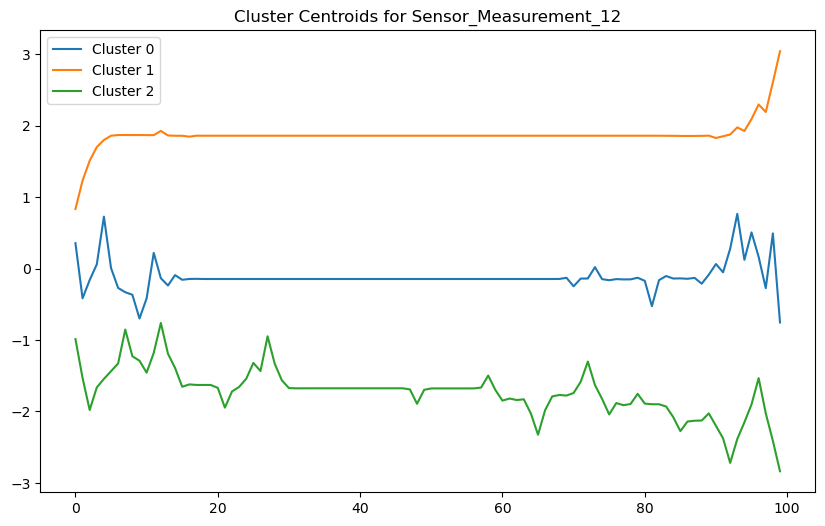

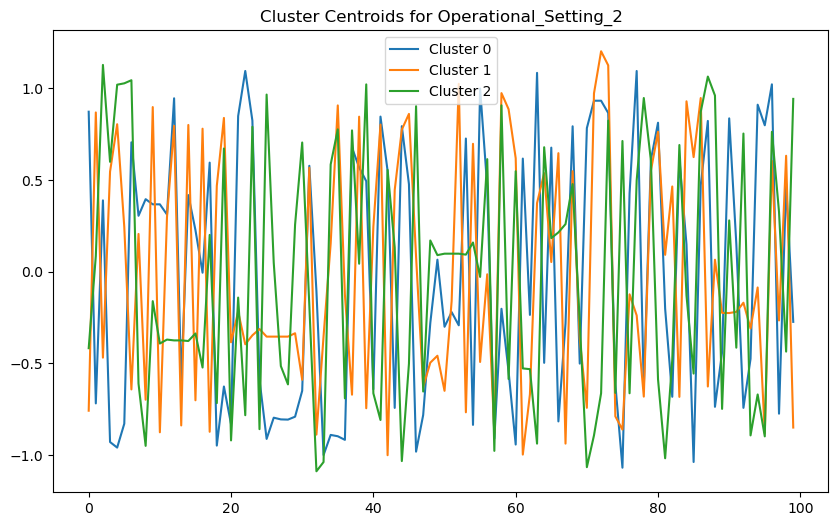

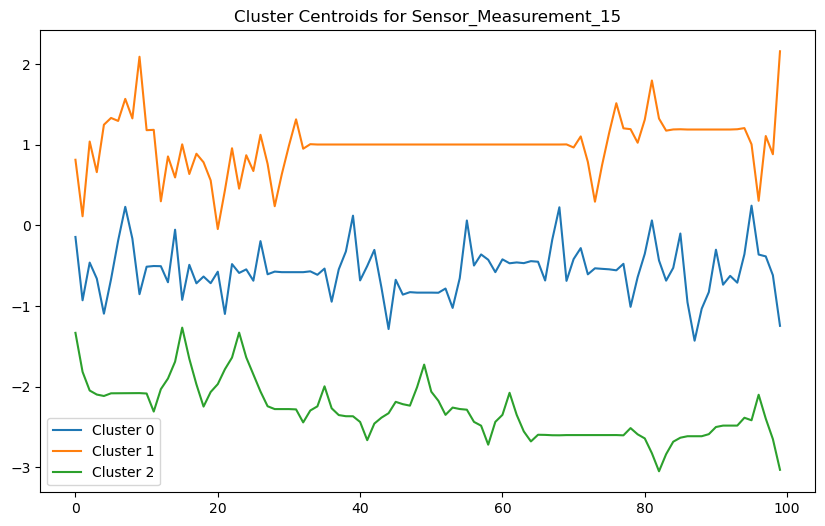

In [88]:
for feature, model in cluster_models.items():
    plt.figure(figsize=(10, 6))
    for i, centroid in enumerate(model.cluster_centers_):
        plt.plot(centroid.ravel(), label=f"Cluster {i}")
    plt.title(f"Cluster Centroids for {feature}")
    plt.legend()
    plt.show()




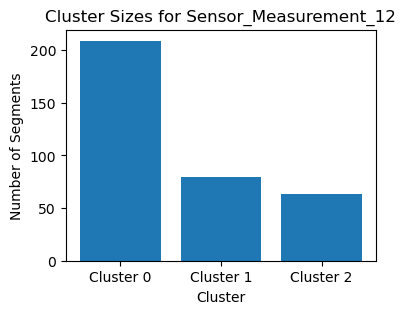

Cluster sizes for Sensor_Measurement_12:
  Cluster 0: 209 segments
  Cluster 1: 80 segments
  Cluster 2: 63 segments


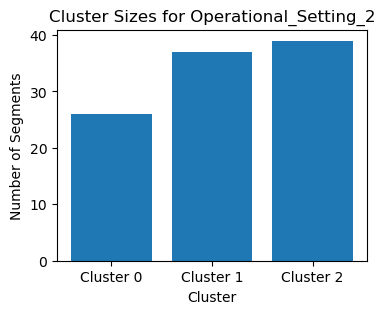

Cluster sizes for Operational_Setting_2:
  Cluster 0: 26 segments
  Cluster 1: 37 segments
  Cluster 2: 39 segments


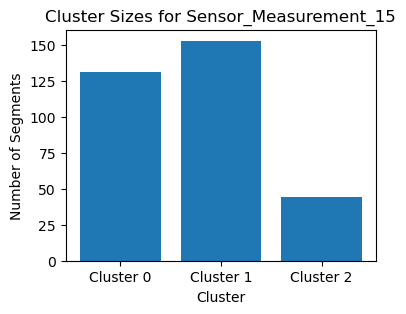

Cluster sizes for Sensor_Measurement_15:
  Cluster 0: 131 segments
  Cluster 1: 153 segments
  Cluster 2: 44 segments


In [89]:
for feature, labels in cluster_labels.items():
    # Count the number of segments in each cluster
    unique, counts = np.unique(labels, return_counts=True)
    cluster_sizes = dict(zip(unique, counts))
    
    plt.figure(figsize=(4, 3))
    plt.bar(unique, counts, tick_label=[f"Cluster {i}" for i in unique])
    plt.title(f"Cluster Sizes for {feature}")
    plt.xlabel("Cluster")
    plt.ylabel("Number of Segments")
    plt.show()
    
    # Print the cluster sizes
    print(f"Cluster sizes for {feature}:")
    for cluster, size in cluster_sizes.items():
        print(f"  Cluster {cluster}: {size} segments")

In [12]:
model_save_path = "clustering_models"

# Save each clustering model in the cluster_models dictionary
for feature, model in cluster_models.items():
    model_filename = f"{model_save_path}/FD003{feature}_clustering_model.pkl"
    dump(model, model_filename)
    
# # Load the saved clustering models
# loaded_cluster_models = {}

# for feature in normalized_segments.keys():
#     model_filename = f"{model_save_path}/{feature}_clustering_model.pkl"
#     loaded_cluster_models[feature] = joblib.load(model_filename)

## linear regression for each cluster

In [13]:
# Create a mapping of cluster assignments to original rows
cluster_to_original_rows = {}

for feature, labels in cluster_labels.items():
    cluster_to_original_rows[feature] = []
    for i, label in enumerate(labels):
        metadata = segments_mapping[feature][i]
        unit_number = metadata["unit_number"]
        start_idx = metadata["start_idx"]
        end_idx = metadata["end_idx"]
        
        # Map each original row in the segment to the cluster
        cluster_to_original_rows[feature].append({
            "unit_number": unit_number,
            "start_idx": start_idx,
            "end_idx": end_idx,
            "cluster": label
        })

In [14]:
def get_windowdf_rows_by_cluster(feature, cluster_id):
    original_rows = []
    for mapping in cluster_to_original_rows[feature]:
        if mapping["cluster"] == cluster_id:
            unit = mapping["unit_number"]
            start, end = mapping["start_idx"], mapping["end_idx"]
            
            # Retrieve the original rows for the segment
            rows = result_df[
                (result_df["Unit_Number"] == unit) &
                (result_df["Time_in_Cycles"] >= start) &
                (result_df["Time_in_Cycles"] < end)
            ]
            original_rows.append(rows)
    
    return pd.concat(original_rows)


In [15]:
print(features)

['Sensor_Measurement_12', 'Operational_Setting_2', 'Sensor_Measurement_15']


In [16]:
level2_models = {}

for cluster_feature in features:
    for cluster_number_id in range(3):
        
        cluster_rows = get_windowdf_rows_by_cluster(cluster_feature, cluster_number_id)

        features_draft = [col for col in cluster_rows.columns if col not in ['Max_Life', 'RUL', 'normalized_time','Unit_Number','Time_in_Cycles_mean','Time_in_Cycles_variance','Time_in_Cycles_slope']]

        cluster_rows = cluster_rows.fillna(0)

        X = cluster_rows[features_draft]
        y = cluster_rows['RUL']
        X_train_with_const = sm.add_constant(X)


        linear_model = sm.OLS(y, X_train_with_const)
        linear_model_fit = linear_model.fit()

        # Get the p-values from the fitted model
        p_values = linear_model_fit.pvalues

        # Filter for columns with p-value > 0.05
        insignificant_features = p_values[p_values > 0.05].index.tolist()

        features_draft = [col for col in features_draft if col not in insignificant_features]

        t_stats = linear_model_fit.tvalues

        # Sort the t-statistics by absolute value
        sorted_features_by_tstat = t_stats.abs().sort_values(ascending=False)

        filtered_t_stats = {key: value for key, value in t_stats.items() if key in features_draft}
        t_stats_df = pd.DataFrame(list(filtered_t_stats.items()), columns=["Feature", "T_Value"])

        # Identify sensor-stationary pairs
        sensor_pairs = []
        for feature in t_stats_df['Feature']:
            if "_stationary" in feature:
                original = feature.replace("_stationary", "")
                if original in t_stats_df['Feature'].values:
                    sensor_pairs.append((original, feature))


        kept_features = []

        for original, stationary in sensor_pairs:
            t_original = t_stats_df.loc[t_stats_df['Feature'] == original, 'T_Value'].values[0]
            t_stationary = t_stats_df.loc[t_stats_df['Feature'] == stationary, 'T_Value'].values[0]
            if abs(t_stationary) > abs(t_original):
                if original in features_draft: 
                    features_draft.remove(original)
            else:
                if stationary in features_draft: features_draft.remove(stationary)

        # Ensure this loop will refine features_draft until all p-values < 0.05
        while True:

            # Prepare the features (X) and target (y)
            X = cluster_rows[features_draft]
            y = cluster_rows['RUL']
            X_train_with_const = sm.add_constant(X)

            # Fit the linear model
            linear_model2 = sm.OLS(y, X_train_with_const)
            linear_model_fit2 = linear_model2.fit()

            # Get p-values
            p_values = linear_model_fit2.pvalues

            # Identify features with p-values > 0.05
            insignificant_features = p_values[p_values > 0.05].index.tolist()

            # Exclude 'const' from insignificant features if present
            insignificant_features = [col for col in insignificant_features if col != 'const']

            # Break the loop if there are no insignificant features
            if not insignificant_features:
                break

            # Update features_draft by removing insignificant features
            features_draft = [col for col in features_draft if col not in insignificant_features]

        level2_models[f'{cluster_feature},{cluster_number_id}'] = (linear_model_fit2,linear_model_fit2.summary())
        dump((linear_model_fit2, X_train_with_const.columns), f"FD003{cluster_feature}_c{cluster_number_id}_model_and_columns.joblib")


In [17]:
print(level2_models)

{'Sensor_Measurement_12,0': (<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9ce5bbc490>, <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                    RUL   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     774.8
Date:                Sun, 15 Dec 2024   Prob (F-statistic):               0.00
Time:                        20:27:21   Log-Likelihood:            -1.1216e+05
No. Observations:               20295   AIC:                         2.244e+05
Df Residuals:                   20260   BIC:                         2.247e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                            

# testing

In [29]:
column_names_first_5 = ['Unit_Number', 'Time_in_Cycles', 'Operational_Setting_1', 'Operational_Setting_2', 'Operational_Setting_3']

remaining_column_names = [f'Sensor_Measurement_{i}' for i in range(1,22)]

column_names = column_names_first_5 + remaining_column_names

test1 = pd.read_csv("test_FD003.txt", delim_whitespace=True, names=column_names)

## generate columns for testing data

In [30]:
def generate_remaining_columns(df):
    exponential_growth = ['Sensor_Measurement_2', 'Sensor_Measurement_3', 'Sensor_Measurement_4','Sensor_Measurement_11']

    # Process exponential growth features
    for feature in exponential_growth:
        # Apply log transformation
        df[f"{feature}_stationary"] = np.log(df[feature])

    
    rolling_columns = [col for col in df.columns if col not in ['Max_Life', 'RUL', 'normalized_time','Unit_Number']]


    result = []
    window_size = 20

    for unit, group in df.groupby("Unit_Number"):
        group = group.sort_values("Time_in_Cycles")  # Ensure data is sorted by time

        for feature in rolling_columns:
            if feature in group.columns:
                # Initialize temporary lists for this feature and unit
                unit_means = []
                unit_variances = []
                unit_slopes = []

                # Iterate over rolling windows
                for i in range(len(group)):
                    window = group.iloc[max(0, i - window_size + 1): i + 1]

                    # Compute mean and variance
                    unit_means.append(window[feature].mean())
                    unit_variances.append(window[feature].var())

                    # Compute slope if there's enough data
                    if len(window) > 1:
                        slope, _, _, _, _ = linregress(window["Time_in_Cycles"], window[feature])
                        unit_slopes.append(slope)
                    else:
                        unit_slopes.append(np.nan)

                # Add new columns to the group
                group[f'{feature}_mean'] = unit_means
                group[f'{feature}_variance'] = unit_variances
                group[f'{feature}_slope'] = unit_slopes

        # Append the processed group to the result
        result.append(group)

    # Concatenate all processed groups back together
    final_df = pd.concat(result, axis=0).reset_index(drop=True)

    return final_df

In [31]:
test1_full = generate_remaining_columns(test1)

## assign each unit's last segment to its cluster

In [32]:
def assign_last_segment_to_cluster(test_data, features, cluster_models, segments_mapping):
    assigned_clusters = {}

    for feature in features:
        # Extract test data for the feature
        test_feature_data = test_data[feature].values

        # Scale the test feature
        scaler = StandardScaler()
        scaled_test_feature = scaler.fit_transform(test_feature_data.reshape(-1, 1)).flatten()

        # Detect change points using Ruptures
        model = rpt.Pelt(model="l2").fit(scaled_test_feature)
        change_points = model.predict(pen=10)  # Use the same penalty as training

        # Extract the last segment
        start_idx = change_points[-2] if len(change_points) > 1 else 0
        end_idx = len(scaled_test_feature)
        last_segment = scaled_test_feature[start_idx:end_idx]

        # Normalize the last segment
        normalized_last_segment = normalize_segment_length(last_segment, length=100)

        # Convert to the correct format for the model
        normalized_last_segment = normalized_last_segment.reshape(1, -1)

        # Assign the last segment to the closest cluster
        cluster_model = cluster_models[feature]
        cluster_label = cluster_model.predict(normalized_last_segment)[0]

        # Store the result
        assigned_clusters[feature] = {
            "cluster_label": cluster_label,
            "start_idx": start_idx,
            "end_idx": end_idx
        }

    return assigned_clusters

In [33]:
test_data = test1_full[test1_full["Unit_Number"] == 1]

assigned_clusters = assign_last_segment_to_cluster(
    test_data=test_data,
    features=['Sensor_Measurement_12', 'Operational_Setting_2', 'Sensor_Measurement_15'],
    cluster_models=cluster_models,
    segments_mapping=segments_mapping
)


In [34]:
print(assigned_clusters)

{'Sensor_Measurement_12': {'cluster_label': 1, 'start_idx': 200, 'end_idx': 233}, 'Operational_Setting_2': {'cluster_label': 2, 'start_idx': 0, 'end_idx': 233}, 'Sensor_Measurement_15': {'cluster_label': 2, 'start_idx': 210, 'end_idx': 233}}


## get weighted prediction based on assigned clusters

In [35]:
def calculate_weighted_prediction(test_data, assigned_clusters, df_threshold=5):
    total_weight = 0
    weighted_sum = 0

    # Iterate through the assigned clusters
    for cluster_feature, details in assigned_clusters.items():
        cluster_number_id = details["cluster_label"]

        # Retrieve the corresponding model and its details
        model_key = f"{cluster_feature},{cluster_number_id}"
        model_fit, summary = level2_models[model_key]
        r2_value = model_fit.rsquared
        df_model = model_fit.df_model  # Degree of freedom of the model

        # Calculate scaling factor based on df_model
        scaling_factor = min(1, df_model / df_threshold)

        # Final weight for the model
        weight = r2_value * scaling_factor

        # Load the saved model and its features
        filename = f"FD003{cluster_feature}_c{cluster_number_id}_model_and_columns.joblib"
        linear_model_fit2, model_features = load(filename)

        # Prepare the test data for the model
        test_data = test_data.copy()
        test_data["const"] = 1  # Add intercept
        filtered_data = test_data[model_features].fillna(0)

        # Get the prediction for the current model
        filtered_data_last = filtered_data.iloc[-1]  # Use the last row of test data
        prediction = linear_model_fit2.predict(filtered_data_last)

        # Accumulate the weighted sum and total weight
        weighted_sum += prediction * weight
        total_weight += weight

    # Calculate the weighted average prediction
    if total_weight > 0:
        return weighted_sum / total_weight
    else:
        return 0  # Handle edge case where no models have a valid weight

In [36]:
import warnings
from statsmodels.tsa.api import SimpleExpSmoothing

# Ignore specific warning from tslearn
warnings.filterwarnings("ignore", message="2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries")

# Ignore SettingWithCopyWarning globally
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)


def test_dataset_fit(test_data_frame):
    RUL_predictions = []

    for unit_number, group in test_data_frame.groupby("Unit_Number"):
        # Get test data for the current unit
        test_data = test_data_frame[test_data_frame["Unit_Number"] == unit_number]

        # Assign clusters to the last segment of the test data
        assigned_clusters = assign_last_segment_to_cluster(
            test_data=test_data,
            features=['Sensor_Measurement_12', 'Operational_Setting_2', 'Sensor_Measurement_15'],
            cluster_models=cluster_models,
            segments_mapping=segments_mapping
        )

        # Get predictions and weights from all relevant models
        weighted_prediction = calculate_weighted_prediction(test_data, assigned_clusters)

        # Use exponential smoothing to stabilize predictions
        y_train = []
        for i in range(1, 11):  # Take the last 10 data points
            prediction = weighted_prediction
            y_train.append(prediction)

        fit3 = SimpleExpSmoothing(y_train, initialization_method="estimated").fit()
        fcast3 = fit3.forecast(1)
        RUL_predictions.append(fcast3[0])

    return RUL_predictions
    
        
test1_RUL_Predict = test_dataset_fit(test1_full)

In [37]:
RUL_real = pd.read_csv("RUL_FD003.txt",names=['RUL'])  # Replace "file.csv" with your actual file path

# # Extract the integers into a list
RUL_real = RUL_real.iloc[:, 0].tolist()  # Assuming the integers are in the first column
print(RUL_real)

res = [a - b for a, b in zip(RUL_real, test1_RUL_Predict)]

print(res)

[44, 51, 27, 120, 101, 99, 71, 55, 55, 66, 77, 115, 115, 31, 108, 56, 136, 132, 85, 56, 18, 119, 78, 9, 58, 11, 88, 144, 124, 89, 79, 55, 71, 65, 87, 137, 145, 22, 8, 41, 131, 115, 128, 69, 111, 7, 137, 55, 135, 11, 78, 120, 87, 87, 55, 93, 88, 40, 49, 128, 129, 58, 117, 28, 115, 87, 92, 103, 100, 63, 35, 45, 99, 117, 45, 27, 86, 20, 18, 133, 15, 6, 145, 104, 56, 25, 68, 144, 41, 51, 81, 14, 67, 10, 127, 113, 123, 17, 8, 28]
[-9.114820957780886, -19.996952503617237, -11.236963283120758, -29.60887545066572, -28.80193446936778, -45.22308850060398, 16.594026195115504, 6.843514244060472, 1.7600515223261866, -27.373619056825703, 21.078557684880785, -0.08206921124876487, -11.881185958517818, -6.8095221867676585, -28.901550896871754, -84.03558686036342, 21.164523283802765, 16.406553260526096, -81.24668569022805, -32.348830973437344, -0.42736471591662095, -3.840086557702733, 12.255835857645863, -4.4078210793155765, 12.23005667720588, -39.013115754175466, -35.91110370241752, -27.472697803985483

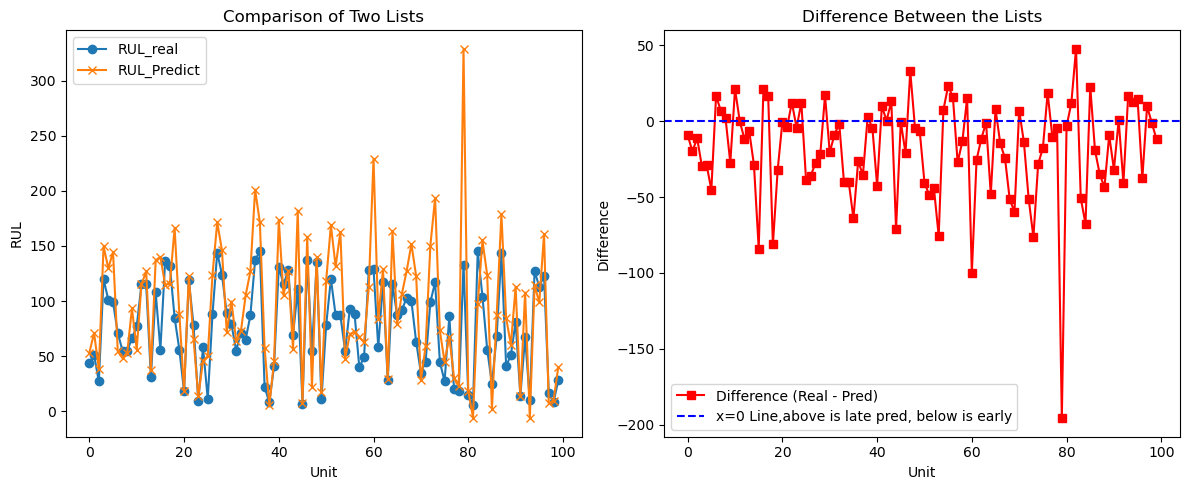

In [38]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the two lists against each other in the first subplot
axs[0].plot(RUL_real, label="RUL_real", marker='o')
axs[0].plot(test1_RUL_Predict, label="RUL_Predict", marker='x')
axs[0].set_title('Comparison of Two Lists')
axs[0].set_xlabel('Unit')
axs[0].set_ylabel('RUL')
axs[0].legend()

# Plot the difference in the second subplot
axs[1].plot(res, label="Difference (Real - Pred)", color='red', marker='s')
axs[1].axhline(0, color='blue', linestyle='--', label="x=0 Line,above is late pred, below is early")  # Add a horizontal line at x=0
axs[1].set_title('Difference Between the Lists')
axs[1].set_xlabel('Unit')
axs[1].set_ylabel('Difference')
axs[1].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

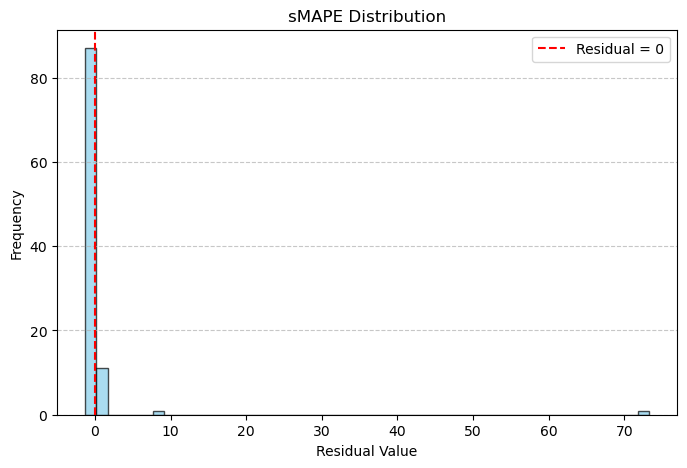

In [44]:
res_ratio = [(a - b)/((a+b)/2) for a, b in zip(RUL_real, test1_RUL_Predict)]
plt.figure(figsize=(8, 5))
plt.hist(res_ratio, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label='Residual = 0')  # Reference line at 0
plt.title('sMAPE Distribution')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

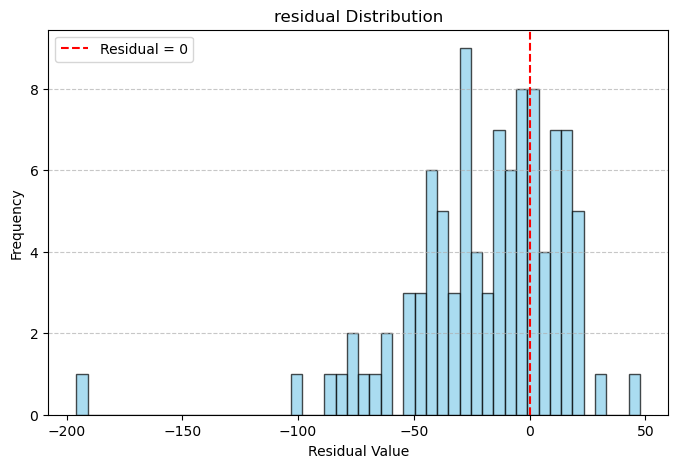

In [87]:
res= [a - b for a, b in zip(RUL_real, test1_RUL_Predict)]
plt.figure(figsize=(8, 5))
plt.hist(res, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label='Residual = 0')  # Reference line at 0
plt.title('residual Distribution')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [40]:
def test_dataset_fit_without_ep(test_data_frame):
    RUL_predictions = []

    for unit_number, group in test_data_frame.groupby("Unit_Number"):
        # Get test data for the current unit
        test_data = test_data_frame[test_data_frame["Unit_Number"] == unit_number]

        # Assign clusters to the last segment of the test data
        assigned_clusters = assign_last_segment_to_cluster(
            test_data=test_data,
            features=['Sensor_Measurement_12', 'Operational_Setting_2', 'Sensor_Measurement_15'],
            cluster_models=cluster_models,
            segments_mapping=segments_mapping
        )

        # Get predictions and weights from all relevant models
        weighted_prediction = calculate_weighted_prediction(test_data, assigned_clusters)
        
        RUL_predictions.append(weighted_prediction)

    return RUL_predictions
    
        
test1_RUL_Predict_2 = test_dataset_fit_without_ep(test1_full)


In [41]:
res_ratio2 = [(a - b)/((a+b)/2) for a, b in zip(RUL_real, test1_RUL_Predict_2)]


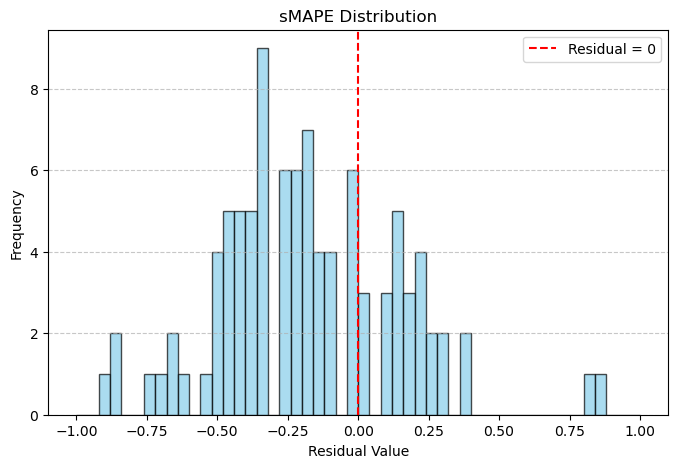

In [45]:
res_ratio2 = [float(x) for x in res_ratio2]  # Ensure it's a numeric 1D array

# Plot the histogram with adjustments
plt.figure(figsize=(8, 5))
plt.hist(res_ratio2, bins=50, range=(-1, 1), color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label='Residual = 0')  # Reference line at 0
plt.title('sMAPE Distribution')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


we'll keep the simple expensional in prediction for this dataset. 

## check each unit's prediction during its life time

In [79]:
def predict_unit_life(test_data_frame, unit_number, step=10):
    """
    Predict RUL for a specific unit every `step` data points.

    Args:
        test_data_frame (DataFrame): The dataset containing test data.
        unit_number (int): The unit number to process.
        step (int): The interval at which predictions are made.

    Returns:
        dict: Contains the unit number and its predictions.
    """
    # Filter data for the specified unit and sort by time
    unit_data = test_data_frame[test_data_frame["Unit_Number"] == unit_number].sort_values("Time_in_Cycles")
    predictions = []

    # Generate predictions at every `step`
    for i in range(0, len(unit_data), step):
        # Select the data range for prediction
        data_subset = unit_data.iloc[i:i + step]

        if len(data_subset) < step:  # Skip incomplete steps at the end
            continue

        # Predict RUL for the current subset
        assigned_clusters = assign_last_segment_to_cluster(
            test_data=data_subset,
            features=['Sensor_Measurement_12', 'Operational_Setting_2', 'Sensor_Measurement_15'],
            cluster_models=cluster_models,
            segments_mapping=segments_mapping
        )

        # Get raw prediction and convert to a numerical value
        prediction = calculate_weighted_prediction(data_subset, assigned_clusters)
        if isinstance(prediction, pd.Series):  # Extract value from Series if needed
            prediction = prediction.values[0]
        predictions.append({"index": i, "prediction": prediction})

    return {"unit_number": unit_number, "predictions": predictions}

In [80]:
#cherry pick
def calculate_slope_for_all_units(test_data_frame, step=10):
    """
    Loop through all units, calculate predictions, and compute the slope for each unit.

    Args:
        test_data_frame (DataFrame): The dataset containing test data.
        step (int): The interval at which predictions are made.

    Returns:
        list of dict: Each dict contains the unit number, predictions, and slope.
    """
    unit_slopes = []

    for unit_number in test_data_frame["Unit_Number"].unique():
        # Generate predictions for the unit
        unit_result = predict_unit_life(test_data_frame, unit_number, step)

        # Extract predictions and indices
        indices = [p["index"] for p in unit_result["predictions"]]
        values = [p["prediction"] for p in unit_result["predictions"]]

        # Ensure values are numerical
        values = [v for v in values if isinstance(v, (int, float))]

        # Calculate slope using linear regression
        if len(indices) > 1 and len(indices) == len(values):
            slope, _, _, _, _ = linregress(indices, values)
            unit_result["slope"] = slope
        else:
            unit_result["slope"] = None  # Handle cases where slope cannot be calculated

        unit_slopes.append(unit_result)

    return unit_slopes

In [82]:
unit_slopes = calculate_slope_for_all_units(test1_full, step=10)

In [84]:
closest_unit = None
min_diff = float("inf")

for unit in unit_slopes:
    if unit["slope"] is not None:
        diff = abs(unit["slope"] - (-1))
        if diff < min_diff:
            min_diff = diff
            closest_unit = unit

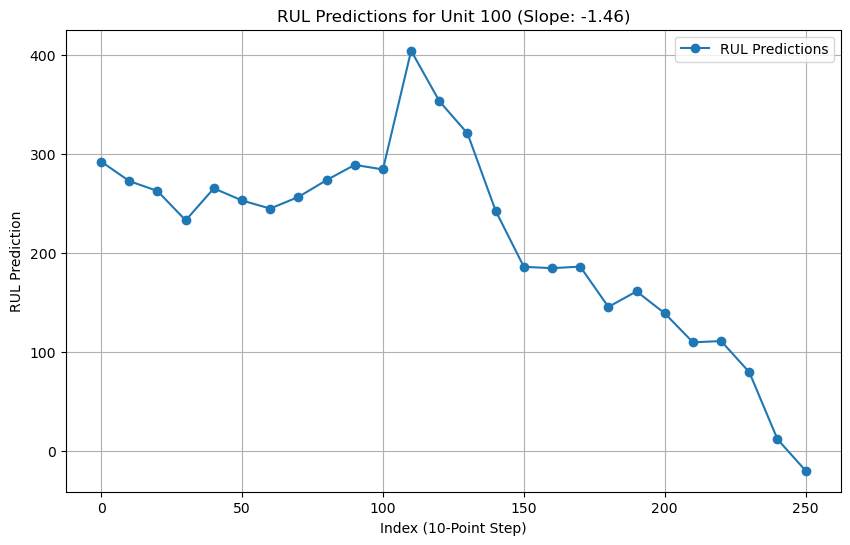

In [85]:
predictions = closest_unit["predictions"]
indices = [p["index"] for p in predictions]
values = [p["prediction"] for p in predictions]

plt.figure(figsize=(10, 6))
plt.plot(indices, values, marker="o", label="RUL Predictions")
plt.title(f"RUL Predictions for Unit {unit['unit_number']} (Slope: {unit['slope']:.2f})")
plt.xlabel("Index (10-Point Step)")
plt.ylabel("RUL Prediction")
plt.legend()
plt.grid()
plt.show()